# DATA 512 - Wildfire Analysis - Project Part 1 - Common Analysis

## Data Analysis and Prediction Modelling Step

### Baisakhi Sarkar, University of Washington, MSDS 2023-2025


More and more frequently summers in the western US have been characterized by wildfires with smoke billowing across multiple western states. There are many proposed causes for this: climate change, US Forestry policy, growing awareness, just to name a few. Regardless of the cause, the impact of wildland fires is widespread as wildfire smoke reduces the air quality of many cities. There is a growing body of work pointing to the negative impacts of smoke on health, tourism, property, and other aspects of society.

The course project will require that us to analyze wildfire impacts on a specific city in the US. The end goal is to be able to inform policy makers, city managers, city councils, or other civic institutions, to make an informed plan for how they could or whether they should make plans to mitigate future impacts from wildfires.

The common analysis research question is based on one specific dataset. We get the [Combined wildland fire datasets for the United States](https://www.sciencebase.gov/catalog/item/61aa537dd34eb622f699df81) and certain territories, 1800s-Present (combined wildland fire polygons) dataset. This dataset was collected and aggregated by the US Geological Survey. The dataset is relatively well documented. The dataset provides fire polygons in ArcGIS and GeoJSON formats. 

Wildland fires within 650 miles of Palmdale, California are analyzed for the last 60 years (1964-2021). A smoke estimate is then created to estimate the wildfire smoke impact which is later modeled to make predictions for the next 25 years (until 2050).

Wildland fires within 1250 miles of Palmdale, California are analyzed for the last 60 years (1964-2020). This section of the notebook uses the Final_Wildfire_Data_Cleaned.csv generated from the Wildfire_Analysis_Data_Cleaning.ipynb notebook , and the Yearly_AQI_Data.csv generated from the Wildfire_Analysis_Data_Acquisition.ipynb notebook Using these datasets, a smoke estimate is created which is then evaluated using the AQI levels. The smoke estimate is then modeled to generate predictions from 2025 to 2050. Visualizations are also created at the end to generate further insights.

### Step 1: Preliminaries



In [166]:
# These are standard python modules
import pandas as pd
import warnings

# The modules below are not standard Python modules
# You will need to install these with pip/pip3 if you do not already have it
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [167]:
# Suppress the warning statements
warnings.filterwarnings("ignore")

### Step 2: Reading the Widfire Cleaned dataset into a pandas dataframe

In [168]:
# Read the CSV data into a dataframe
wf_df = pd.read_csv('../Intermediate_files/Final_Wildfire_Data_Cleaned.csv')
wf_df_all = pd.read_csv("../Intermediate_files/Past_60_years_wildfires_with_distances_from_Palmdale.csv")

In [169]:
wf_df.head()

,Unnamed: 0,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Listed_Fire_Names,Circleness_Scale,Shape_Length,Shape_Area,Closest_Distance_Miles
0,0,14600,Wildfire,1964,65338.877640,COYOTE (4),0.263753,112240.801495,2.644171e+08,78.287919
1,1,14601,Wildfire,1964,55960.694158,"C. HANLY (5), Hanley (1)",0.224592,112566.141954,2.264649e+08,367.502205
2,2,14602,Wildfire,1964,19218.105903,COZY DELL (5),0.138493,84004.974692,7.777292e+07,37.284539
3,3,14603,Wildfire,1964,18712.494750,HAYFORK HWY. #2 (5),0.391960,49273.004457,7.572678e+07,490.145821
4,4,14604,Wildfire,1964,16887.001024,"MATTOLE (5), ROBERTS COOP. ESCAPE (5)",0.392989,46746.577459,6.833927e+07,513.197125


In [170]:
wf_df.shape

(45891, 10)

Our data has 45891 records and 9 usable features

In [171]:
wf_df['Assigned_Fire_Type'].unique()

array(['Wildfire', 'Unknown - Likely Wildfire', 'Prescribed Fire',
       'Likely Wildfire', 'Unknown - Likely Prescribed Fire'],
      dtype=object)

### Step 3: Creating Smoke Estimate

Now, we need to create an annual estimate of wildfire smoke in Palmdale, California. This estimate is just a number that we will eventually use to build a predictive model. It seems reasonable that a large fire burning a large number of acres, and that is close to our city would put more smoke into a city than a small fire that is much further away. We will thus use the variables 'GIS_Acres' and 'Closest_Distance_Miles' to define our smoke estimate and then apply it to every fire within 650 miles of our city between 1964 and 2021.

Before that, we need to make the two variables consistent in terms of their units. This is done by converting the 'GIS_Acres' variable to square miles since the 'Distance' values are stored as miles. 

In [172]:
# Convert 'GIS_Acres' to square miles and store the values in a new column 'GIS_Square_Miles'
wf_df['GIS_Square_Miles'] = wf_df['GIS_Acres']*0.0015625

Now, lets plot the two variables to understand their relationship. 

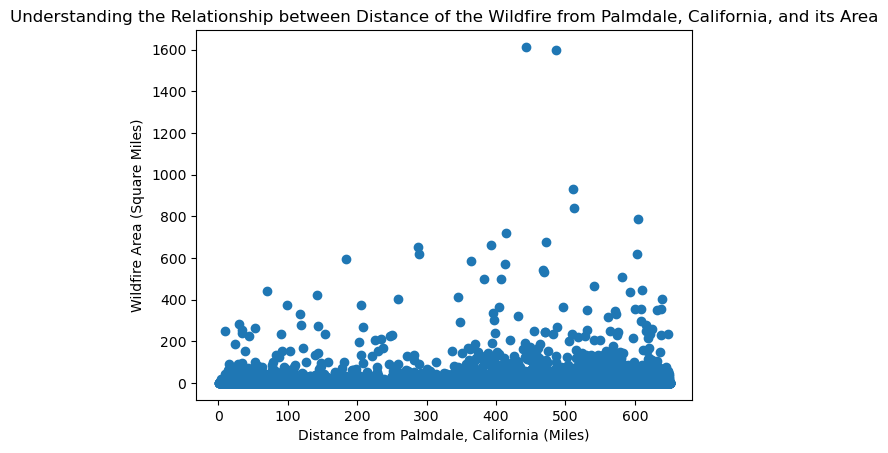

In [173]:
# Plotting 'Distance' and 'GIS_Square_Miles'
plt.scatter(wf_df['Closest_Distance_Miles'], wf_df['GIS_Square_Miles'])

# Set labels and show plot
plt.xlabel('Distance from Palmdale, California (Miles)')
plt.ylabel('Wildfire Area (Square Miles)')
plt.title('Understanding the Relationship between Distance of the Wildfire from Palmdale, California, and its Area')
plt.show()

The relationship in the above plot looks random where most of the wildfires are concetrated in smaller areas region. we dont see any visible trend or relationship.

Now we will try plotting the square of the 'Closest_Distance_Miles' with the 'GIS_Square_Miles' variable to find out if there is any trend in that.

In [174]:
# Compute the square of the Closest_Distance_Miles and store it in a new column called 'Closest_Distance_Square_Miles'
wf_df['Closest_Distance_Square_Miles'] = (wf_df['Closest_Distance_Miles'])**2

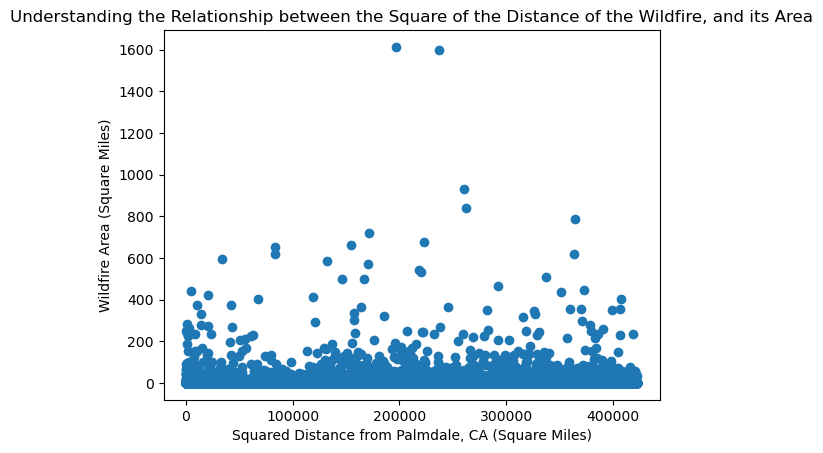

In [175]:
# Plotting 'Distance_Square' and 'GIS_Square_Miles'
plt.scatter(wf_df['Closest_Distance_Square_Miles'], wf_df['GIS_Square_Miles'])

# Set labels and show plot
plt.xlabel('Squared Distance from Palmdale, CA (Square Miles)')
plt.ylabel('Wildfire Area (Square Miles)')
plt.title('Understanding the Relationship between the Square of the Distance of the Wildfire, and its Area')
plt.show()

Since we still dont have a trend between the two variables selected we will chcek the trend between GIS_square_Miles showing how far the fire was from our city Palmdale, CA and another varibale named 'Circleness_Scale' which refers to a geometric measure of how circular or compact a fire polygon is. This type of metric can be useful in understanding the shape and spread patterns of fires. It might indicate how irregular or elongated the fire area was, which can help in studying fire behavior and its containment challenges.

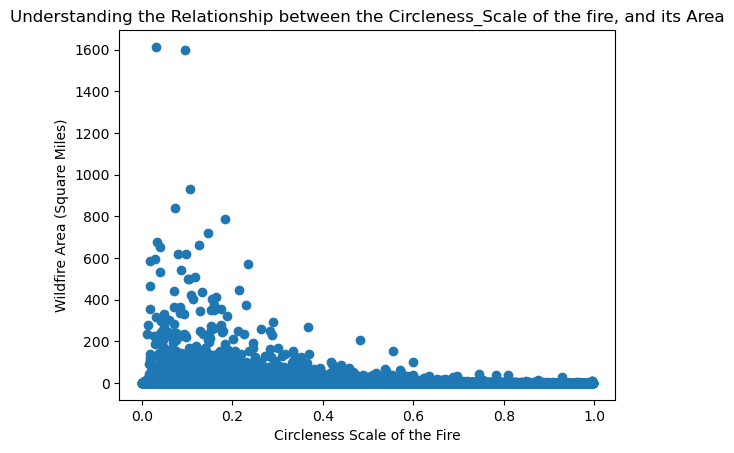

In [176]:
# Plotting 'Distance_Square' and 'GIS_Square_Miles'
plt.scatter(wf_df['Circleness_Scale'], wf_df['GIS_Square_Miles'])

# Set labels and show plot
plt.xlabel('Circleness Scale of the Fire')
plt.ylabel('Wildfire Area (Square Miles)')
plt.title('Understanding the Relationship between the Circleness_Scale of the fire, and its Area')
plt.show()

After checking the relationship between some features, we will take into consideration the distance of the fire from Palmdale, CA to make an estimate of the smoke in the city since we assume that further the fire, lesser will be the smoke. But when area of the fire is more we can expect the smoke to be more as well.

Thus, the smoke estimate that best captures our intuition can be created using the following formula,

*Smoke Estimate = w1 x Area of Fire x (exp(Circleness_scale)) x (1/(w2 x Distance^2)*

where w1 and w2 are constants

The aim is to not have a very high smoke estimate value. The intention is to keep it under 50. Based on the existing data points, w1 and w2 were chosen in such a way that the overall smoke estimate value stays under 50. Thus w1 and w2 for this analysis were chosen only to keep the number of digits of 'Closest_Distance_Square_Miles' and 'GIS_Square_Miles' under control.

Since 'GIS_Square_Miles' is usually in hundreds, w1 is chosen as 1/50 to reduce the overall value of smoke estimate. Similarly, since 'Distance_Square' is a very high value usually in hundred tshousands, w2 is chosen as 1/1000000 to curb the digits. Thus, the final smoke estimate looks as follows,

*Smoke Estimate = (Area of Fire x exp(-Distance^2/100000))/50*

Using the above formula, smoke estimate is calculated for every fire in the dataset.

In [177]:
# Calculate Smoke Estimate for every fire in the dataset
#wf_df['Smoke_Estimate'] = wf_df['GIS_Square_Miles']*(np.exp(-wf_df['Circleness_Scale']))*((1/wf_df['Closest_Distance_Square_Miles'])/100000)/100
wf_df['Smoke_Estimate'] = wf_df['GIS_Square_Miles']*np.exp(-wf_df['Closest_Distance_Square_Miles']/1000000)/50


### Step 4: Analyzing the Smoke Estimate

The next step is to understand how the smoke estimate for each fire will be used to find one smoke estimate for every year. This can be done by taking the cumulative of smoke estimate during each year or by amortizing over the fire season (May 1st to October 31st).

To make this decision, the total number of wildfires were plotted for every year.

In [178]:
# Group the dataframe by the fire year and find the total number of wildfires for each year
count_by_year = wf_df.groupby(['Fire_Year'])['USGS_Assigned_ID'].count().reset_index()

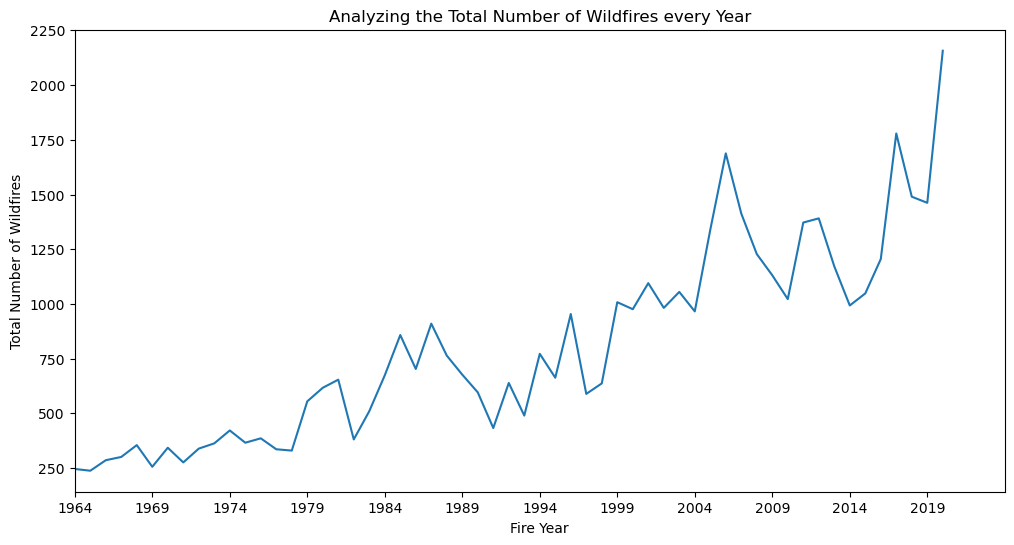

In [179]:
# Plot the total number of wildfires against the fire year
plt.figure(figsize=(12, 6))
plt.plot(count_by_year['Fire_Year'], count_by_year['USGS_Assigned_ID'])

# Set labels and show plot
plt.xlabel('Fire Year')
plt.ylabel('Total Number of Wildfires')
plt.title('Analyzing the Total Number of Wildfires every Year')
plt.xlim([1964, 2024]) 
plt.xticks(np.arange(1964, 2024, 5))
plt.show()

It can be seen that the total number of wildfires have increased over time. This change has been quite significant from 1964 to 2020.  Since we are analyzing the "smoke emitted", it would make more sense if we take a cumulative of the smoke estimate. This will take the large number of wildfires in recent times into account.

So we now find the Cumulative Smoke Estimate for every year and save it to a new dataframe.

In [180]:
wf_df

,Unnamed: 0,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Listed_Fire_Names,Circleness_Scale,Shape_Length,Shape_Area,Closest_Distance_Miles,GIS_Square_Miles,Closest_Distance_Square_Miles,Smoke_Estimate
0,0,14600,Wildfire,1964,65338.877640,COYOTE (4),0.263753,112240.801495,2.644171e+08,78.287919,102.091996,6128.998184,2.029364
1,1,14601,Wildfire,1964,55960.694158,"C. HANLY (5), Hanley (1)",0.224592,112566.141954,2.264649e+08,367.502205,87.438585,135057.870439,1.527841
2,2,14602,Wildfire,1964,19218.105903,COZY DELL (5),0.138493,84004.974692,7.777292e+07,37.284539,30.028290,1390.136829,0.599732
3,3,14603,Wildfire,1964,18712.494750,HAYFORK HWY. #2 (5),0.391960,49273.004457,7.572678e+07,490.145821,29.238273,240242.925744,0.459881
4,4,14604,Wildfire,1964,16887.001024,"MATTOLE (5), ROBERTS COOP. ESCAPE (5)",0.392989,46746.577459,6.833927e+07,513.197125,26.385939,263371.288770,0.405529
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45886,117147,135046,Prescribed Fire,2020,20.327632,2_PHMA_FIAT_Beulah_East_Bendire_NW_Malheur_Pri...,0.407603,1592.532526,8.226301e+04,645.322932,0.031762,416441.687068,0.000419
45887,117152,135051,Prescribed Fire,2020,16.737098,Malheur WS Alder Creek 02 (1),0.318826,1633.905090,6.773263e+04,611.460888,0.026152,373884.417676,0.000360
45888,117153,135052,Prescribed Fire,2020,60.879054,2_PHMA_FIAT_Beulah_East_Bendire_NW_Malheur_Pri...,0.028211,10475.782440,2.463688e+05,648.440662,0.095124,420475.291774,0.001249
45889,117155,135054,Prescribed Fire,2020,10.429138,SOD 121 (1),0.511658,1018.118440,4.220522e+04,617.228369,0.016296,380970.858950,0.000223


In [181]:
# Create a new dataframe that has yearly data and the cumulative smoke estimate values
smoke_by_year = wf_df.groupby(['Fire_Year'])['Smoke_Estimate'].sum().reset_index()

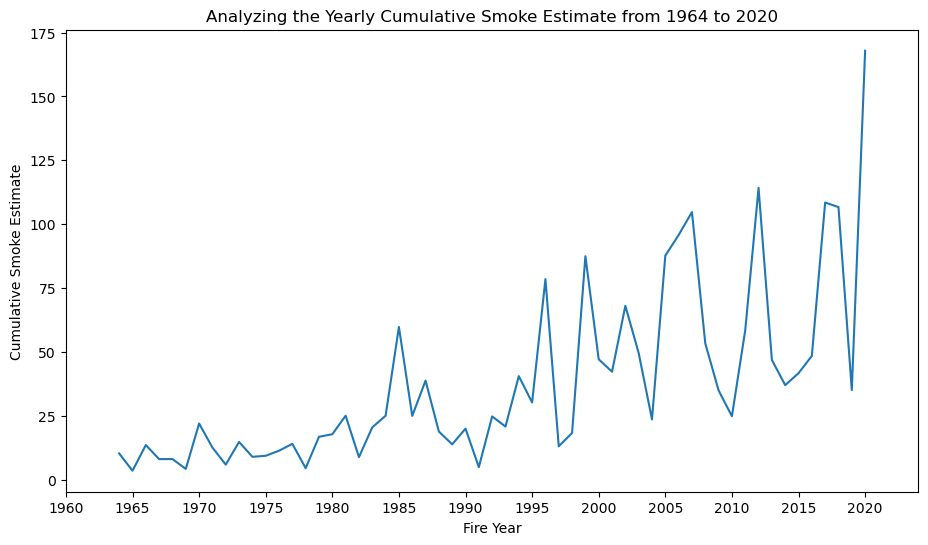

In [182]:
# Plot the cumulative smoke estimate with the fire year
plt.figure(figsize=(11, 6))
plt.plot(smoke_by_year['Fire_Year'], smoke_by_year['Smoke_Estimate'])

# Set labels and show plot
plt.xlabel('Fire Year')
plt.ylabel('Cumulative Smoke Estimate')
plt.title('Analyzing the Yearly Cumulative Smoke Estimate from 1964 to 2020')
plt.xlim([1960, 2024]) 
plt.xticks(np.arange(1960, 2024, 5))
plt.show()

From the plot above, there seems to be some kind of periodicity existing. The smoke estimate goes up at a peak every 3-5 years. The size of the peaks is also increasing upto the year 2007.

### Step 5: Evaluating the Smoke Estimate's Performance Using US EPA Air Quality Data

The next step is trying to understand how good or bad our smoke estimate might be. Now that we have developed our smoke estimate, we will compare our estimate to the AQI (Air Quality Index) data from the US EPA. This data was retrieved from the API in the Data Retrieval notebook.

In [183]:
# Read the AQI data from a CSV file to a dataframe
aqi_df = pd.read_csv('../Intermediate_Files/Yearly_AQI_Data.csv')

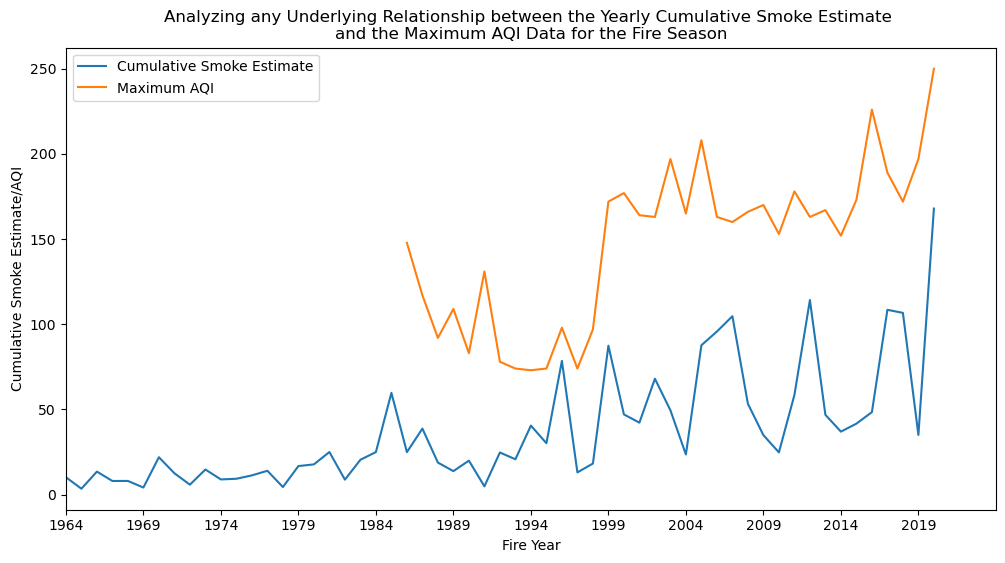

In [184]:
# Plot the cumulative smoke estimate and the maximum AQI data for every year
plt.figure(figsize=(12, 6))
plt.plot(smoke_by_year['Fire_Year'], smoke_by_year['Smoke_Estimate'], label='Cumulative Smoke Estimate')
plt.plot(aqi_df['Year'], aqi_df['AQI'], label='Maximum AQI')

# Set labels and show plot
plt.xlabel('Fire Year')
plt.ylabel('Cumulative Smoke Estimate/AQI')
plt.title('Analyzing any Underlying Relationship between the Yearly Cumulative Smoke Estimate \n\
and the Maximum AQI Data for the Fire Season')
plt.xlim([1964, 2024]) 
plt.xticks(np.arange(1964, 2024, 5))
plt.legend()
plt.show()

As evident from the above plot, the Maximum AQI data for the fire season of every year is missing for the years 1964-1985. However, for the years where the data is available, there seems to be a dependent relationship between the two variables - Cumulative Smoke Estimate and the Maximum AQI. The peaks and dips are mostly in sync for both the curves. However, there are a few instances where these don't match.

The AQI measures air pollution levels, which can arise from various sources, not solely wildfires. While wildfires are a significant contributor to poor air quality and can substantially impact the AQI, other factors and sources also influence air pollution levels. Some of these other sources are industrial emissions, vehicle emissions, construction activities, etc. Thus, while there might be a relationship between both the variables we cannot assume that wildfires are the sole reason for poor AQI.

Overall, the curves are quite smilar in their trends indicating that our smoke estimate is capturing the data well.

### Step 6: Modeling the Smoke Estimate

The plot of the Cumulative Smoke Estimate reveals complex patterns, including peaks, falls, and irregular variations, which are challenging to capture with traditional linear regression models. A Long Short-Term Memory (LSTM) network, a type of recurrent neural network (RNN) designed to handle sequential data, is well-suited for this type of time series forecasting. LSTM models are known for their ability to retain historical dependencies, making them ideal for capturing long-term trends and seasonality in volatile data.

While additional features such as AQI data could enhance the accuracy of the model, the lack of consistent AQI measurements over more than 20 years makes it impractical to include. Therefore, the LSTM model will rely solely on the cumulative smoke estimate to generate predictions.

For the model to perform effectively, several preprocessing steps are required. The 'Fire_Year' column must be converted into a pandas datetime object and set as the index of the DataFrame. The input data is then scaled to a range between 0 and 1 using MinMaxScaler to ensure smooth learning during model training. The historical smoke estimates are used in sequential windows to train the model to capture temporal dependencies.

This LSTM model will allow us to forecast future smoke estimates from 2021 to 2050, providing valuable insights for long-term trend analysis and environmental planning.


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0743  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0746 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0621
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0834
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0730
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0488
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0413
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0391
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0455
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0445
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0379
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0484
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0464
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0307 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0372
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

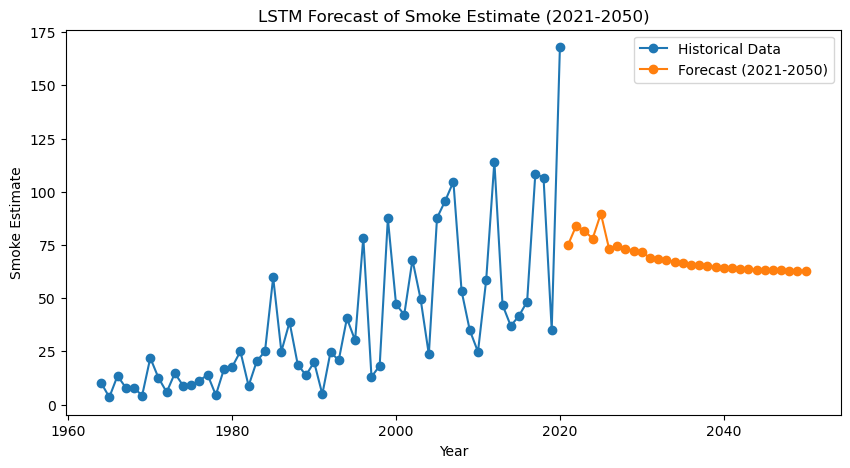

In [185]:

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# Step 1: Prepare the Data
lstm_df = smoke_by_year.copy()

# Ensure 'Fire_Year' is treated as datetime and set as index
lstm_df['date'] = pd.to_datetime(lstm_df['Fire_Year'], format='%Y')
lstm_df = lstm_df.set_index('date')

# Drop unnecessary columns (if any)
lstm_df = lstm_df[['Smoke_Estimate']]

# Scale the data for LSTM input
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(lstm_df)

# Step 2: Create Sequences of Data for Training
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Use the last 5 years as a sequence window size
window_size = 5
X, y = create_sequences(scaled_data, window_size)

# Reshape the data to fit the LSTM input: (samples, time_steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Step 3: Build the LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X.shape[1], 1), return_sequences=True))
model.add(Dropout(0.3))  # Add dropout to prevent overfitting
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 4: Train the Model
model.fit(X, y, epochs=50, batch_size=16, verbose=1)

# Step 5: Forecast Future Values (2021-2050)
# Use the last 'window_size' values from the dataset to predict future values
last_sequence = scaled_data[-window_size:].reshape((1, window_size, 1))

# Generate predictions for 30 years (2021-2050)
predictions = []
# Generate predictions for 30 years (2021-2050)
for _ in range(30):
    # Predict the next value
    next_value = model.predict(last_sequence)[0, 0]  # Extract the scalar prediction
    predictions.append(next_value)  # Store the prediction

    # Reshape the predicted value to match the sequence's shape (1, 1, 1)
    next_value_reshaped = np.array(next_value).reshape(1, 1, 1)

    # Update the sequence by removing the first element and adding the new prediction
    last_sequence = np.append(last_sequence[:, 1:, :], next_value_reshaped, axis=1)

# Inverse scale the predictions to original values
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Print the forecasted predictions
print(predictions)

# Step 6: Create a DataFrame with Forecasted Values
forecast_years = np.arange(2021, 2051)
forecast_df = pd.DataFrame({'Year': forecast_years, 'Smoke_Estimate': predictions.flatten()})

# Display the forecasted DataFrame
print(forecast_df)

# Optional: Plot the Forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(lstm_df.index.year, lstm_df['Smoke_Estimate'], label='Historical Data', marker='o')
plt.plot(forecast_df['Year'], forecast_df['Smoke_Estimate'], label='Forecast (2021-2050)', marker='o')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.title('LSTM Forecast of Smoke Estimate (2021-2050)')
plt.legend()
plt.show()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 5, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 5, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


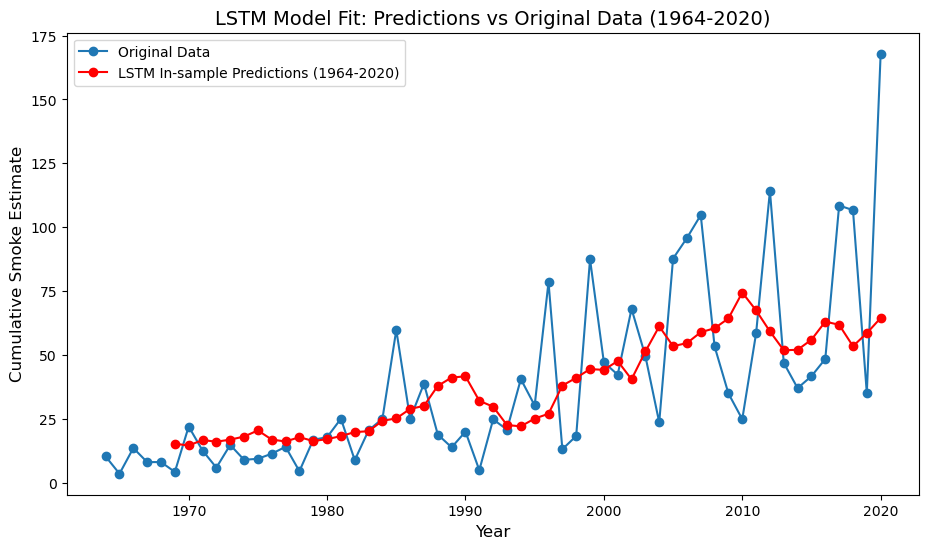

In [186]:
# Print the LSTM model summary
print(model.summary())

# now we want to check how well our LSTM model matched with the original data.

# Step 1: Prepare the data (input sequences for the period 1964-2020)
window_size = 5  # Assuming we are using the last 5 years for prediction

# Create sequences from the original data for in-sample prediction (1964-2020)
scaled_data = scaler.transform(smoke_by_year[['Smoke_Estimate']].values)  # Scaled original data
X_in_sample, y_in_sample = create_sequences(scaled_data, window_size)  # Reuse the sequence creation function

# Step 2: Generate predictions using the LSTM model for 1964-2020
y_pred_scaled = model.predict(X_in_sample)  # Get predictions in scaled form
y_pred = scaler.inverse_transform(y_pred_scaled)  # Inverse transform to original scale

# Step 3: Prepare data for plotting
years = smoke_by_year['Fire_Year'].values[window_size:]  # Matching the years to predictions (after window size)

# Step 4: Plot the original data vs LSTM predictions
plt.figure(figsize=(11, 6))

# Plot the original cumulative smoke estimate
plt.plot(smoke_by_year['Fire_Year'], smoke_by_year['Smoke_Estimate'], label='Original Data', marker='o')

# Plot the LSTM in-sample predictions for 1964-2020
plt.plot(years, y_pred.flatten(), 'r-', label='LSTM In-sample Predictions (1964-2020)', marker='o')

# Set labels, title, and legend
plt.xlabel('Year', fontsize=12)
plt.ylabel('Cumulative Smoke Estimate', fontsize=12)
plt.title('LSTM Model Fit: Predictions vs Original Data (1964-2020)', fontsize=14)
plt.legend()
plt.show()



The LSTM model provides a powerful tool for capturing the sequential dependencies and non-linear patterns in the Cumulative Smoke Estimate data. However, deep learning models like LSTM can sometimes overfit, and the predictions may exhibit non-intuitive trends, especially when working with smaller datasets or volatile time series. To validate the LSTM model's predictions and explore the data from another perspective, we also employ the Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors (SARIMAX) model.

The SARIMAX model is well-suited for time series data with both seasonality and trend components. Unlike LSTM, SARIMAX leverages statistical properties of the data, making it effective for modeling time series with continuous peaks and falls. This model also allows for the inclusion of exogenous variables (such as AQI data) to improve prediction accuracy. However, due to missing AQI data for more than 20 years, the SARIMAX model in this case only uses the smoke estimate data to capture patterns and make forecasts.

For the SARIMAX model to function correctly, the date column is set as the index of the DataFrame and converted to a pandas datetime object. This ensures that the time-based structure of the data is appropriately utilized by the model.

By comparing the SARIMAX predictions with the LSTM forecast, we can gain deeper insights into the reliability and robustness of both models, helping to identify long-term trends in the smoke estimates from 2021 to 2050.

In [187]:
# Create a copy of the dataframe containing yearly cumulative smoke estimate data
sarimax_df = smoke_by_year.copy()

# Convert the year column to datetime and save it as a new column called 'date'
sarimax_df['date'] = pd.to_datetime(sarimax_df['Fire_Year'], errors='ignore', format='%Y')

# Set the above date column as the dataframe's index
sarimax_df = sarimax_df.set_index('date')

# Change the index to datetime object and convert into the type 'datetime64[ns]'
# It is important to convert it to the type 'datetime64[ns]' because the default type is numpy datetime
# A datetime format other than 'datetime64[ns]' throws an error while training the model
sarimax_df.index = pd.to_datetime(sarimax_df.index).astype('datetime64[ns]')

# We then drop the 'Fire_Year' column as it is no longer needed
sarimax_df.drop(['Fire_Year'], axis=1, inplace=True)

In [188]:
# Look at the top of the dataframe
sarimax_df

,Smoke_Estimate
date,
1964-01-01,10.211164
1965-01-01,3.458062
1966-01-01,13.504803
1967-01-01,8.002194
1968-01-01,8.022790
1969-01-01,4.160344
1970-01-01,21.933398
1971-01-01,12.543684
1972-01-01,5.843266


In [189]:
# Fit a SARIMAX model
# Set the order and season_order parameters as per your requirements
# The fourth coordinate of the seasonal_order parameter is set to 12 for yearly data
model = sm.tsa.SARIMAX(sarimax_df['Smoke_Estimate'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

# Generate a list of years for our range of 1963 to 2020
years_range = np.arange(1964, 2021, 1)

# Create a datetime index with the type 'datetime64[ns]'
future_index = pd.to_datetime(years_range, format='%Y').astype('datetime64[ns]')

# Generate predictions using the start date, end date and the time-series index
forecast = results.get_prediction(start=future_index[0], end=future_index[-1], exog=sarimax_df.index)

# Extract the predicted mean values for the years 1963 to 2020
Y_pred = list(forecast.predicted_mean)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83511D+00    |proj g|=  2.22701D-01

At iterate    5    f=  3.78043D+00    |proj g|=  2.18004D-02

At iterate   10    f=  3.74999D+00    |proj g|=  1.55575D-02

At iterate   15    f=  3.74968D+00    |proj g|=  2.56724D-03

At iterate   20    f=  3.74915D+00    |proj g|=  4.15207D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     28      1     0     0   2.297D-05   3.749D+00
  F =   3.7491535085852377     

CONVERG

 This problem is unconstrained.


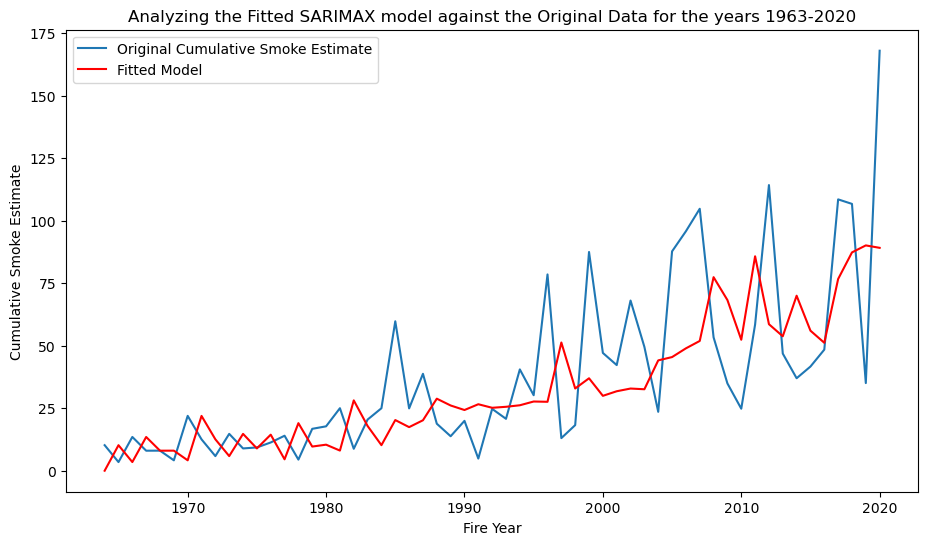

In [190]:
# Plot the original data with the fitted model
X = list(smoke_by_year['Fire_Year'])
Y = list(smoke_by_year['Smoke_Estimate'])

plt.figure(figsize=(11, 6))
plt.plot(X, Y, label='Original Cumulative Smoke Estimate')

# Plot the fitted model line
plt.plot(X, Y_pred, 'r-', label='Fitted Model')

# Set labels and show plot
plt.xlabel('Fire Year')
plt.ylabel('Cumulative Smoke Estimate')
plt.title('Analyzing the Fitted SARIMAX model against the Original Data for the years 1963-2020')
plt.legend()
plt.show()

The model does not fully capture the data for the current period, and there is quite some scope for improvement. However, we also do not want to overfit the data. We will go ahead with this model and generate predictions for the smoke estimate.

We will now use the trained model above to predict smoke estimates for every year for the next 29 years (i.e., 2021-2049). While we are currently in the year 2024, predictions are being generated from 2021 onwards since the Smoke Estimate data is available until 2020 only. We will also make sure to convey appropriate levels of uncertainty in our predictions.


In [191]:
# Generate a list of years for our range of 2021 to 2050
years_range = np.arange(2021, 2051, 1)

# Create a datetime index with the type 'datetime64[ns]'
future_index = pd.to_datetime(years_range, format='%Y').astype('datetime64[ns]')

# Generate predictions using the start date, end date and the time-series index
forecast = results.get_prediction(start=future_index[0], end=future_index[-1], exog=sarimax_df.index)

# Extract the predicted mean values for the years 2021 to 2049 and their confidence intervals
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

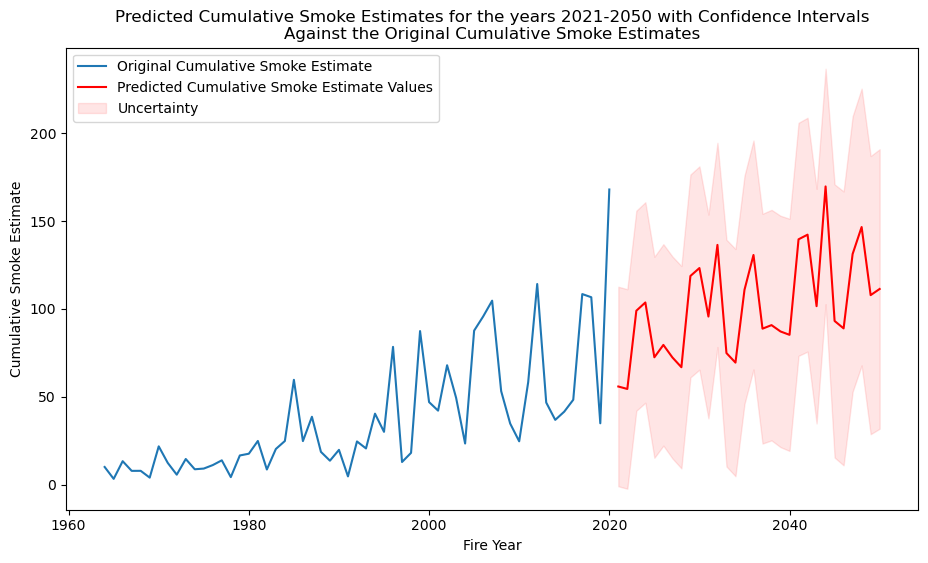

In [192]:
# Plot the actual data
plt.figure(figsize=(11, 6))
plt.plot(X, Y, label='Original Cumulative Smoke Estimate')

# Plot the predicted values
plt.plot(years_range, forecast_values, color='red', label='Predicted Cumulative Smoke Estimate Values')

# Plot the confidence intervals
plt.fill_between(
    years_range,
    list(confidence_intervals.iloc[:, 0]),
    list(confidence_intervals.iloc[:, 1]),
    color='red', alpha=0.1, label='Uncertainty'
)

# Set labels and show plot
plt.legend(loc='upper left')
plt.title('Predicted Cumulative Smoke Estimates for the years 2021-2050 with Confidence Intervals\n\
Against the Original Cumulative Smoke Estimates')
plt.xlabel('Fire Year')
plt.ylabel('Cumulative Smoke Estimate')
plt.show()

### Step 7: Creating Final Visualizations

We will now illustrate the work of our analysis with a few time series graphs. The wildfire data is annual, so our time series will be on an annual basis. All the time series will cover the analysis range for the years 1964-2020, but not the prediction range.

**1. Distribution of Wildfires by their Distance from Palmdale, California**

We will produce a histogram showing the number of fires occurring every 50 mile distance from Palmdale, California up to 1800 miles.

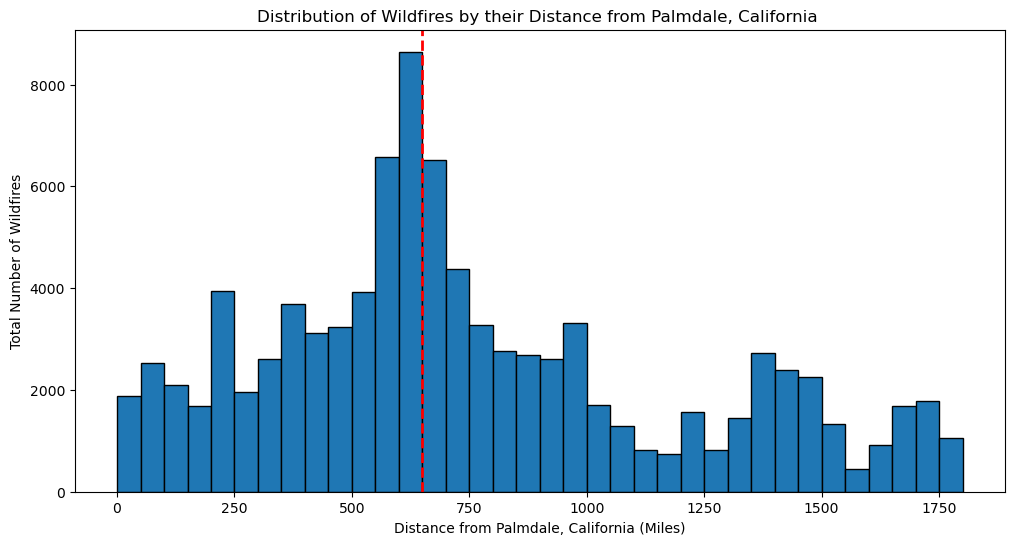

In [194]:
# Plot the distribution of wildfires by their distance from Palmdale, California
plt.figure(figsize=(12, 6))
bins = np.arange(0, 1850, 50)
plt.hist(wf_df_all['Closest_Distance_Miles'], bins=bins, edgecolor='black')

# Add a red dashed vertical line at 650 miles
plt.axvline(x=650, color='red', linestyle='--', linewidth=2, label='650 Miles Cut-off')

# Set labels and show plot
plt.xlabel('Distance from Palmdale, California (Miles)')
plt.ylabel('Total Number of Wildfires')
plt.title('Distribution of Wildfires by their Distance from Palmdale, California ')
# Save the plot as a PNG image locally
plt.savefig('../Results/histogram_distribution_of_wildfires_by_distance.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

It can be observed that the most number of wildfires occur around the 600-650 miles radius of Palmdale, California

**2. Total Acres Burned by Year**

We will produce a time series graph of total acres burned per year for the fires occurring within 650 miles of Palmdale, California.

In [195]:
# Group the data by year and calculate the total burnt acres
acres_by_year = wf_df.groupby(['Fire_Year'])['GIS_Acres'].sum().reset_index()

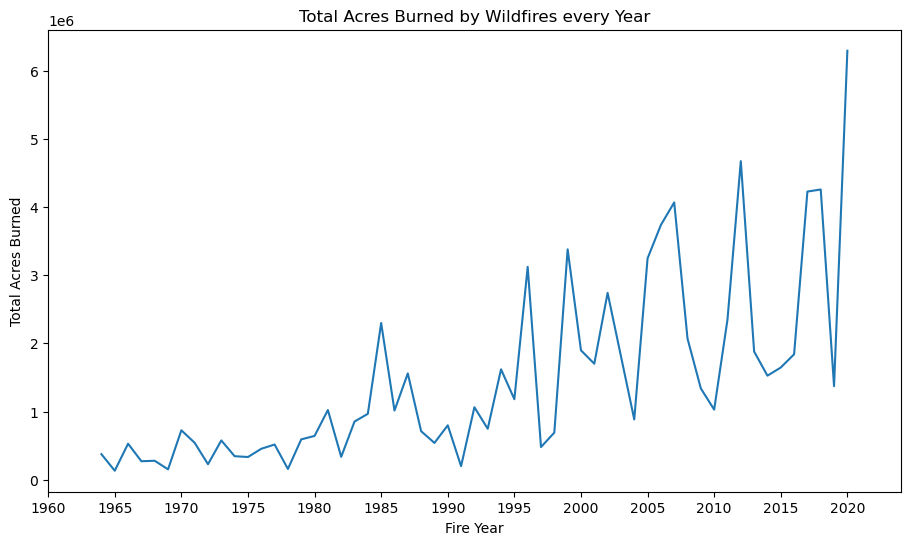

In [196]:
# Plot the total acres burnt every year
plt.figure(figsize=(11, 6))
plt.plot(acres_by_year['Fire_Year'], acres_by_year['GIS_Acres'])

# Set labels and show plot
plt.xlabel('Fire Year')
plt.ylabel('Total Acres Burned')
plt.title('Total Acres Burned by Wildfires every Year')
plt.xlim([1960, 2024]) 
plt.xticks(np.arange(1960, 2024, 5))
# Save the plot as a PNG image locally
plt.savefig('../Results/total_acres_burned.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

**3. Time Series Containing Fire Smoke Estimate and the AQI Estimate**

We will produce a time series graph containing our fire smoke estimate for and the AQI estimate for Palmdale, California

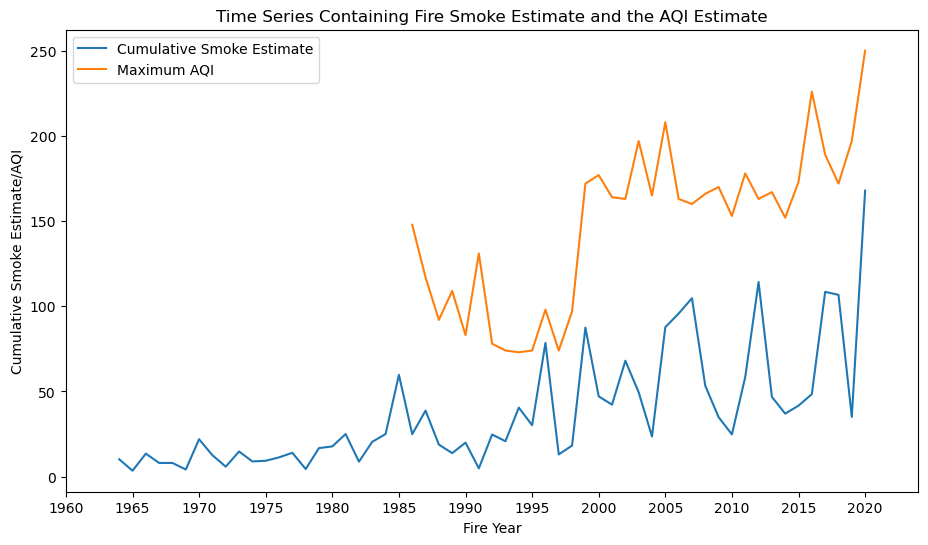

In [197]:
# Plot the cumulative smoke estimate and the maximum AQI data for every year
plt.figure(figsize=(11, 6))
plt.plot(smoke_by_year['Fire_Year'], smoke_by_year['Smoke_Estimate'], label='Cumulative Smoke Estimate')
plt.plot(aqi_df['Year'], aqi_df['AQI'], label='Maximum AQI')

# Set labels and show plot
plt.xlabel('Fire Year')
plt.ylabel('Cumulative Smoke Estimate/AQI')
plt.title('Time Series Containing Fire Smoke Estimate and the AQI Estimate')
plt.xlim([1960, 2024]) 
plt.xticks(np.arange(1960, 2024, 5))
plt.legend()

# Save the plot as a PNG image locally
plt.savefig('../Results/smoke_estimate_vs_aqi_plot.png', format='png', dpi=300, bbox_inches='tight')
plt.show()



As evident from the above plot, the Maximum AQI data for the fire season of every year is missing for the years 1963-1985. However, for the years where the data is available, there seems to be a dependent relationship between the two variables - Cumulative Smoke Estimate and the Maximum AQI. The peaks and dips are mostly in sync for both the curves. However, there are a few instances where these don't match.